# Forcasting Price Change on IPO-day 

### Author：Joy Zhou

### Overview

- [1、Background](#1、Background)
- [2、Functions Define](#2、Functions-Define)
- [3、Data Preprocessing](#3、Data-Preprocessing)    
    - [3.1 Deal with nominal and ordinal features](#3.1-Deal-with-nominal-and-ordinal-features)
    - [3.2 Assessing feature importance with Random Forests](#3.2-Assessing-feature-importance-with-Random-Forests)
- [4、ML Model](#4、ML-Model)    
    - [4.1 Linear Regression](#4.1-Linear-Regression)
    - [4.2 Decision Tree](#4.2-Decision-Tree)
    - [4.3 Random Forest](#4.3-Random-Forest)
    - [4.4 Logistic Regression](#4.4-Logistic-Regression)
    - [4.5 KNN](#4.5-KNN)
    - [4.6 SVM](#4.6-SVM)
    - [4.7 Multi-layer Perceptron](#4.7-Multi--layer-Perceptron)
- [5、Summary](#5、Summary)    
    - [5.1 The relationship about the features and dependent variable](#5.1-The-relationship-about-the-features-and-dependent-variable)
    - [5.2 The forecasting result of the ML model](#5.2-The-forecasting-result-of-the-ML-model)

<br>
<br>

## 1、Background

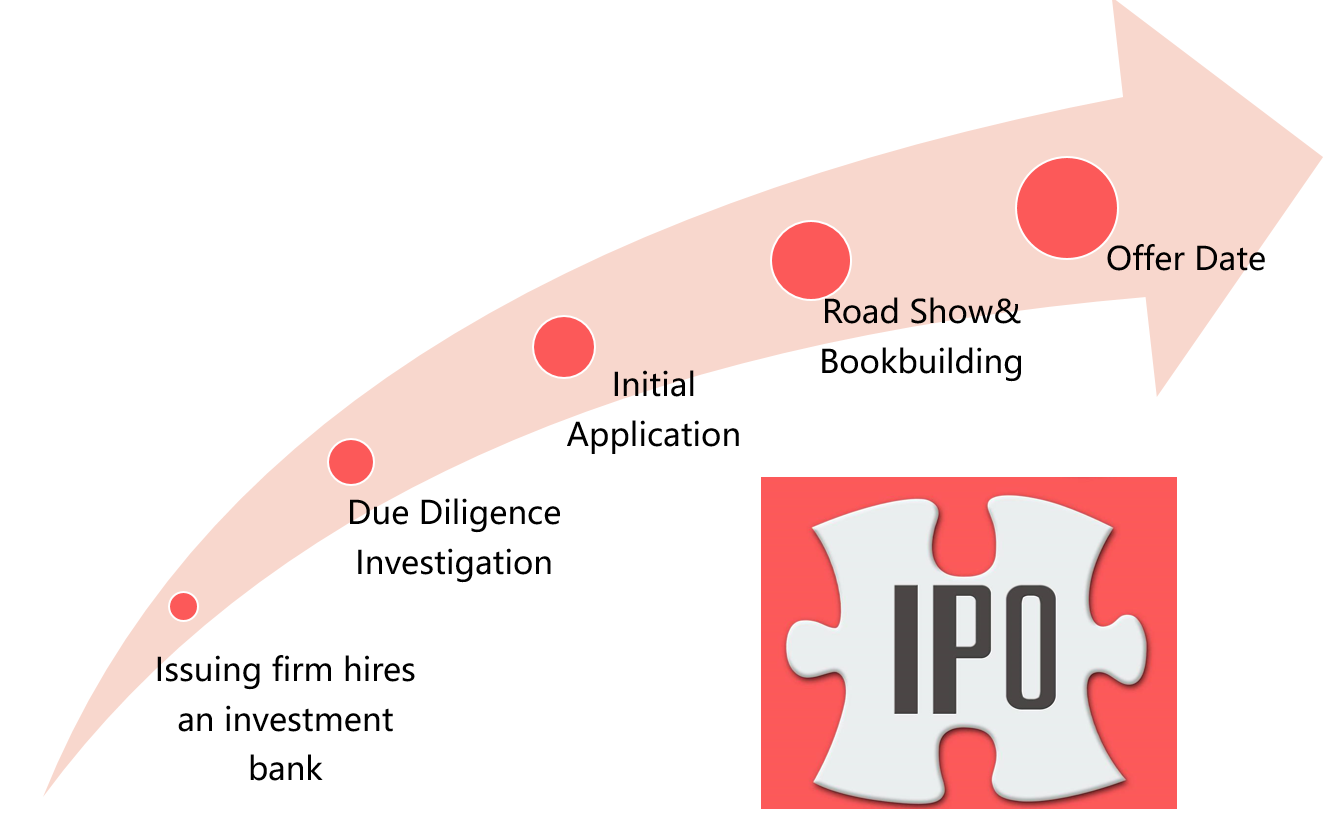

In [146]:
from IPython.display import Image
Image(filename='./images/ipoprocess.png', width=500) 

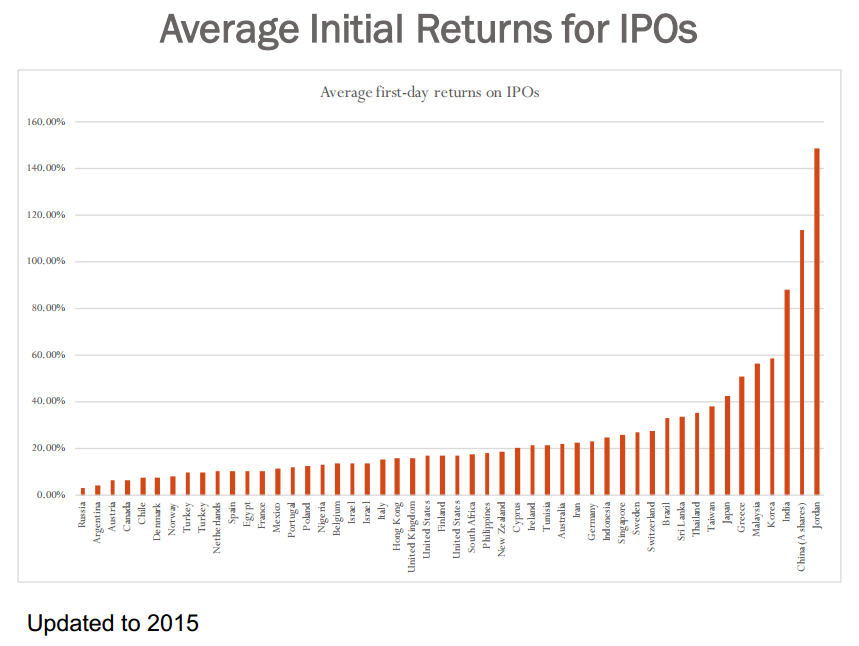

In [13]:
Image(filename='./images/iporeturn.png', width=500) 

After 2014,there was a policy that the return on the ipo day cannot beyond 44%.

Then, it is common to see the stock price have continuous 10% growth for several days.

Thus,for those stocks ipo after 2014,we use the return for 10 days instead.

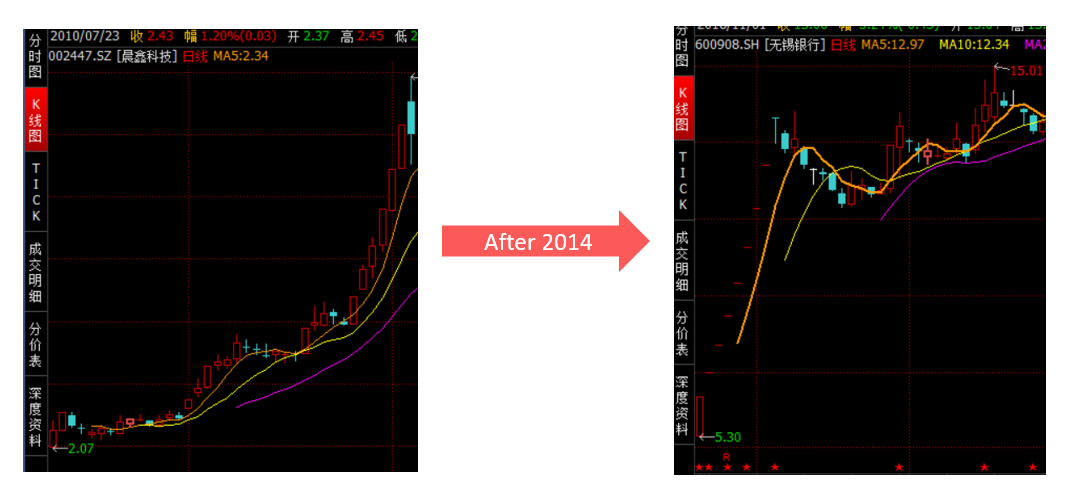

In [195]:
Image(filename='./images/policychange.png', width=600) 

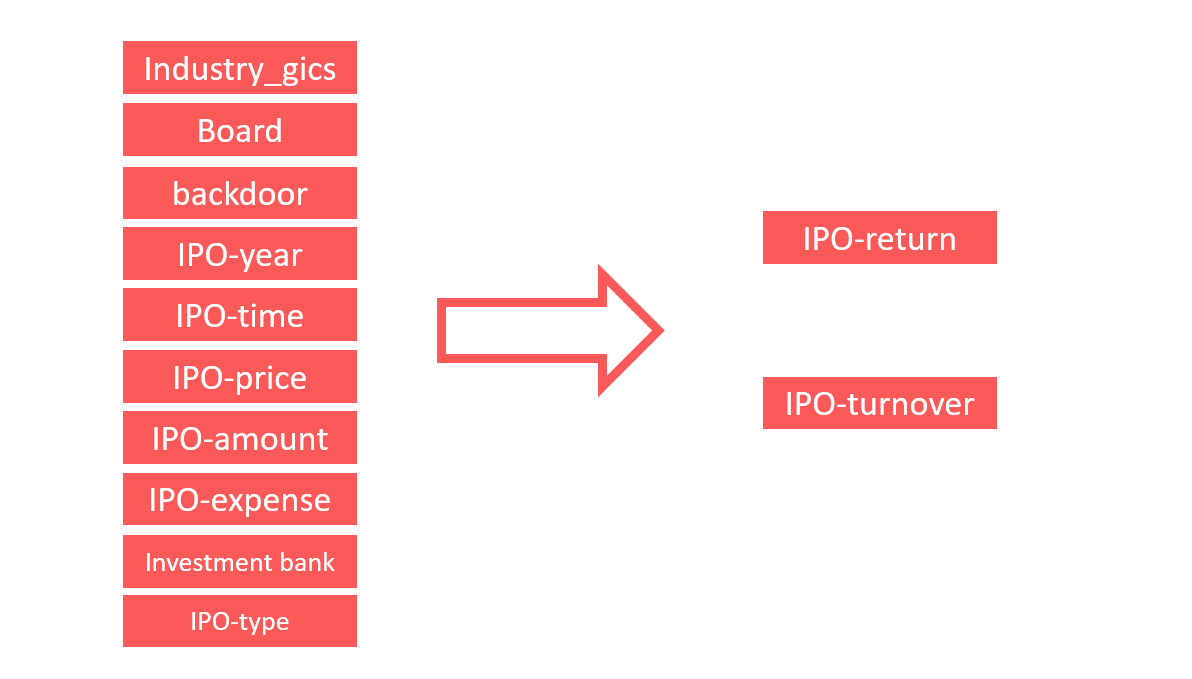

In [55]:
Image(filename='./images/x&y.png', width=600) 

<br>

# 2、Functions Define

In [36]:
import datetime
import numpy as np
import pandas as pd
import time
from __future__ import division
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn.linear_model.logistic import LogisticRegression

<br>

In [86]:
#Transfer the continuous data into discrete data
#label=1:use the 0,1,2...to label the data
#label=0:use the quantile
def discret(contidata,n=5,label=1):
    disdata=np.array(contidata)
    div=list(np.arange(0,100,100/n))
    div.append(100)
    point=[np.percentile(contidata,div[x]) for x in range(n+1)]
    midpoint=[np.percentile(contidata,(div[x]+div[x+1])/2) for x in range(n)]
    if label==0:
            for i in range(n):
                disdata[(disdata>=point[i])&(disdata<=point[i+1])]=midpoint[i]   
    else:
            for i in range(n):
                disdata[(disdata>=point[i])&(disdata<=point[i+1])]=i   
    if label!=0:
        disdata=disdata.astype('int')
    return(disdata)

In [5]:
#delete some element from the range(N)
def drop(N,loc):
        temp=list(range(N))
        for i in loc:
            temp.remove(i)
        return(temp)

In [6]:
def Plotpred(X,y,classfier='linear'):   
    if classfier=='linear':   
        lm = LinearRegression()
        lm.fit(X,y)
        y_pred=lm.predict(X)
    ymin=y.min
    ymax=y.max
    plt.xlim(ymin,ymax)
    plt.ylim(ymin,ymax)
    plt.ylabel('Predicted')
    plt.xlabel('Measured')
    plt.scatter(y_con, y_pred)
    plt.plot(range(ymin,ymax),range(ymin,ymax),color='black',linewidth=3)
    plt.show()

In [7]:
#Plotting the confusion matrix
def confmat(y_true,y_pred):    
    confmat = confusion_matrix(y_true=y_true, y_pred=y_pred)
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()

In [30]:
from scipy import interp   
from sklearn.metrics import roc_curve, auc  
from sklearn.cross_validation import StratifiedKFold  
#plot the ROC curve  
def ROC_CURVE(X,y,classifier):

    n_samples, n_features = X.shape  

    # Add noisy features  
    random_state = np.random.RandomState(0)  
    X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]  
    # Classification and ROC analysis  

    cv = StratifiedKFold(y, n_folds=3)  

    #cv = list(StratifiedKFold(n_splits=3, 
                          #random_state=1).split(X_train, y_train))
    mean_tpr = 0.0  
    mean_fpr = np.linspace(0, 1, 100)  
    all_tpr = []  

    for i, (train, test) in enumerate(cv):  

        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])  
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])  
        mean_tpr += interp(mean_fpr, fpr, tpr)          
        mean_tpr[0] = 0.0                               
        roc_auc = auc(fpr, tpr)  
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))  

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')  

    mean_tpr /= len(cv)                     
    mean_tpr[-1] = 1.0                      
    mean_auc = auc(mean_fpr, mean_tpr)      

    #print mean_fpr,len(mean_fpr)  
    #print mean_tpr  
    plt.plot(mean_fpr, mean_tpr, 'k--',  
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)  

    plt.xlim([-0.05, 1.05])  
    plt.ylim([-0.05, 1.05])  
    plt.xlabel('False Positive Rate')  
    plt.ylabel('True Positive Rate')  
    plt.title('Receiver operating characteristic example')  
    plt.legend(loc="lower right")  
    plt.show()  
    print('Mean AUC: %.3f' % mean_auc)

<br>
<br>

# 3、Data Preprocessing

## 3.1 Deal with nominal and ordinal features

In [158]:
#Set the path
import os
path='C:/Users/admin/Documents/GitHub/2017.M3.TQF-Forcasting-price-change-on-IPO-day'
os.chdir(path)

#read into data
ipodata=pd.read_csv('ipodata.csv',encoding='gbk',index_col=0)
#get the column and row size
[M,N]=ipodata.shape
#Mapping ordinal features
BACKDOOR_map={'否':0,'是':1}
ipodata['BACKDOOR']=ipodata['BACKDOOR'].map(BACKDOOR_map)
ipodata_nobank=ipodata.drop('IPO_LEADUNDR',1)
ipodata_nobank=pd.get_dummies(ipodata_nobank)

In [154]:
#Divide the features and dependent variable
ModelData=ipodata_nobank
Y1_con=ModelData['iporeturn'].values
Y2_con=ModelData['ipoturn'].values
XX=ModelData.drop('iporeturn',1)
XX=(XX.drop('ipoturn',1)).values
XX[:,1]=XX[:,1]-2010
Y1=discret(Y1_con)
Y2=discret(Y2_con)
#normalization
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()  
XX_std=XX.copy()
XX_std[:,2:6]= scaler.fit_transform(XX_std[:,2:6])
temp=drop(ModelData.shape[1],[6,7])
feat_labels_O = np.array((ModelData.columns[temp]))

In [96]:
#Divide the training and testing data
X_train, X_test, y1_train, y1_test = train_test_split(XX,Y1, test_size=0.3, random_state=0)
X_train_con, X_test_con, y1_train_con, y1_test_con = train_test_split(XX,Y1_con, test_size=0.3, random_state=0)

## 3.2 Assessing feature importance with Random Forests

 1) IPO_PRICE                      0.208737
 2) IPO_EXPENSE                    0.177273
 3) IPO_DATE                       0.161760
 4) IPO_AMOUNT                     0.158796
 5) ipotime                        0.116621
 6) INDUSTRY_GICS_工业               0.021917
 7) INDUSTRY_GICS_信息技术             0.018873
 8) INDUSTRY_GICS_可选消费             0.018185
 9) INDUSTRY_GICS_材料               0.017503
10) MKT_中小企业板                      0.015496
11) MKT_主板                         0.015440
12) MKT_创业板                        0.015294
13) INDUSTRY_GICS_医疗保健             0.013478
14) INDUSTRY_GICS_日常消费             0.010628
15) IPO_TYPE_上网定价                  0.007147
16) IPO_TYPE_网下询价,上网定价             0.006514
17) INDUSTRY_GICS_金融               0.004378
18) INDUSTRY_GICS_能源               0.003950
19) INDUSTRY_GICS_公用事业             0.003260
20) BACKDOOR                       0.002548
21) INDUSTRY_GICS_房地产              0.000861
22) INDUSTRY_GICS_电信服务             0.000613
23) IPO_TYPE_战略配售,网下询价,上网定价     

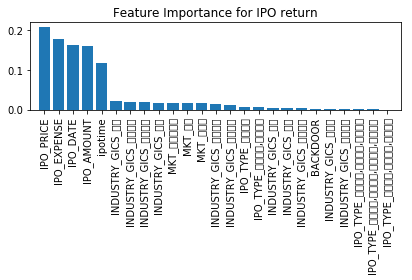

In [97]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)
forest.fit(X_train,y1_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))
plt.title('Feature Importance for IPO return')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('images/04_09.png', dpi=300)
plt.show() 

### As for the importance, we delete the features：backdoor and IPO_TYPE

In [98]:
#temp=drop(ModelData.shape[1],[6,7])
#feat_labels = np.array((ModelData.columns[temp]))
keepf=np.array([1,2,3,4,5,17,18,19])
X=XX[:,keepf]
feat_labels = feat_labels_O [keepf]

#normalization
scaler = preprocessing.StandardScaler()  
X_std=X.copy()
X_std[:,2:6]= scaler.fit_transform(X_std[:,2:6])

In [140]:
X_train, X_test, y1_train, y1_test = train_test_split(X,Y1, test_size=0.3, random_state=1)
X_train_con, X_test_con, y1_train_con, y1_test_con = train_test_split(X,Y1_con, test_size=0.3, random_state=1)
X2_train_con, X2_test_con, y2_train_con, y2_test_con = train_test_split(X,Y2_con, test_size=0.3, random_state=1)
X_train_std, X_test_std, y1_train_std, y1_test_std = train_test_split(X_std,Y1, test_size=0.3, random_state=1)

<br>
<br>

# 4、ML Model

## 4.1 Linear Regression

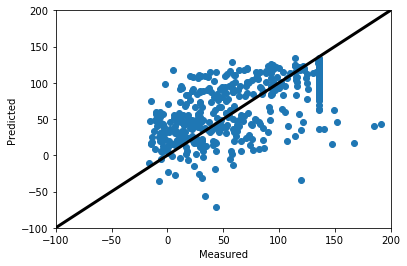

In [186]:
#There are many features, so we plot the real value and predicted value
lm = LinearRegression()
lm.fit(X_train_con,y1_train_con)
Y1_pred=lm.predict(X_test_con)
plt.xlim(-100, 200)
plt.ylim(-100, 200)
plt.ylabel('Predicted')
plt.xlabel('Measured')
plt.scatter(y1_test_con, Y1_pred)
plt.plot(range(-100, 200),range(-100, 200),color='black',linewidth=3)
plt.show()

In [124]:
#TEST the p_value and coef of every feature
import statsmodels.api as sm
est = sm.OLS(y1_train_con,X_train_con).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     137.5
Date:                Sun, 06 May 2018   Prob (F-statistic):          9.71e-151
Time:                        21:16:00   Log-Likelihood:                -6625.8
No. Observations:                1279   AIC:                         1.327e+04
Df Residuals:                    1271   BIC:                         1.331e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             9.9311      0.516     19.263      0.000       8.920      10.943
x2            -0.9462      0.111     -8.515      0.000      -1.164      -0.728
x3          9.923e-09   2.66e-09      3.726      0.000     4.7e-09    1.51e-08
x4          -3.27e-07   5.23e-08     -6.253      0.000    -4.3e-07   -2.24e-07
x5            -0.4155      0.234     -1.780      0.075      -0.874       0.043
x6            79.3931      6.417     12.373      0.000      66.805      91.981
x7            73.0646      7.330      9.968      0.000      58.684      87.445
x8            82.0789      6.419     12.786      0.000      69.485      94.672
==============================================================================
Omnibus:                      691.576   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23838.320
Skew:                           1.881   Prob(JB):                         0.00
Kurtosis:                      23.813   Cond. No.                     6.86e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.86e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [191]:
feat_labels

array(['IPO_DATE', 'IPO_PRICE', 'IPO_AMOUNT', 'IPO_EXPENSE', 'ipotime',
       'MKT_中小企业板', 'MKT_主板', 'MKT_创业板'], dtype=object)

#### Most variables are significant by their P-value
#### The ipo-price and ipo-time have negative impact to the return.
#### The stocks on Main-board are tend to have smaller return

In [164]:
#use the original all data to test and figure out what impact of they have
ipodata_all=pd.get_dummies(ipodata)
X_all=ipodata_all.drop('iporeturn',1)
X_all=(X_all.drop('ipoturn',1)).values
X_all[:,1]=X_all[:,1]-2010
import statsmodels.api as sm
es = sm.OLS(Y1_con,X_all).fit()
es.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     15.27
Date:                Sun, 06 May 2018   Prob (F-statistic):          1.67e-180
Time:                        22:18:40   Log-Likelihood:                -9342.7
No. Observations:                1828   AIC:                         1.890e+04
Df Residuals:                    1720   BIC:                         1.950e+04
Df Model:                         107                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            19.4135     11.084      1.752      0.080      -2.326      41.153
x2             9.5739      0.478     20.042      0.000       8.637      10.511
x3            -0.8560      0.095     -9.007      0.000      -1.042      -0.670
x4          1.418e-08   2.66e-09      5.339      0.000    8.97e-09    1.94e-08
x5         -3.467e-07    4.7e-08     -7.374      0.000   -4.39e-07   -2.54e-07
x6            -0.2956      0.188     -1.573      0.116      -0.664       0.073
x7            12.7749      4.363      2.928      0.003       4.217      21.332
x8            22.5506      9.946      2.267      0.024       3.042      42.059
x9            16.8479      5.000      3.369      0.001       7.041      26.655
x10            6.3334      4.456      1.421      0.155      -2.406      15.073
x11           10.2491      4.099      2.500      0.012       2.210      18.289
x12          -16.6419     22.630     -0.735      0.462     -61.026      27.743
x13            9.7365      5.570      1.748      0.081      -1.189      20.662
x14           11.4761      4.494      2.553      0.011       2.661      20.291
x15           26.4344     27.396      0.965      0.335     -27.298      80.167
x16            8.6169      8.840      0.975      0.330      -8.722      25.955
x17           -6.6010      8.428     -0.783      0.434     -23.131       9.929
x18           34.7438      7.968      4.360      0.000      19.115      50.373
x19           30.8319      8.164      3.777      0.000      14.820      46.844
x20           36.2013      7.980      4.537      0.000      20.550      51.852
x21           31.3723     18.465      1.699      0.089      -4.843      67.588
x22            6.1246     23.810      0.257      0.797     -40.575      52.824
x23           -1.6548     29.055     -0.057      0.955     -58.641      55.331
x24           -8.5556     13.170     -0.650      0.516     -34.386      17.275
x25            3.4244      9.880      0.347      0.729     -15.953      22.802
x26           -5.6228      8.041     -0.699      0.484     -21.393      10.147
x27            4.0500      9.456      0.428      0.668     -14.496      22.596
x28          -31.8056     14.660     -2.170      0.030     -60.558      -3.053
x29            1.7882     10.482      0.171      0.865     -18.770      22.347
x30          -17.8088     12.022     -1.481      0.139     -41.388       5.770
x31            2.9206      5.172      0.565      0.572      -7.224      13.065
x32            1.9129      4.778      0.400      0.689      -7.458      11.283
x33           10.1998     16.953      0.602      0.547     -23.050      43.450
x34            7.8257      8.047      0.973      0.331      -7.957      23.608
x35           22.8480      7.129      3.205      0.001       8.866      36.830
x36            1.5553     13.887      0.112      0.911     -25.682      28.792
x3

#### The back door、industry and ipo-type are not significant, which is consistent with the former result.
#### Some industries tends to have significant higher return: Public utility,health care, Consumer Discretionary,energy 
#### Investment banks like 中原证券 中国银河证券 首创证券 华安证券 兴业证券 have higher return
#### which means these investment banks tend to undervalue the stocks

### Using PCA to the data

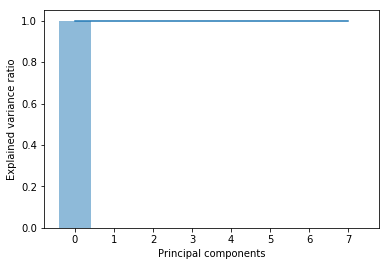

In [132]:
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(X_train_con)
#plot the cummulated explained variance
lengg=len(pca.explained_variance_ratio_)
plt.bar(range(lengg), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(lengg), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

In [190]:
PCAX=X_pca[:,0]
est2 = sm.OLS(y1_train_con,PCAX).fit()
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.280
Date:                Sun, 06 May 2018   Prob (F-statistic):              0.258
Time:                        17:44:07   Log-Likelihood:                -7596.6
No. Observations:                1279   AIC:                         1.520e+04
Df Residuals:                    1278   BIC:                         1.520e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -1.1e-08   9.72e-09     -1.132      0.258   -3.01e-08    8.07e-09
==============================================================================
Omnibus:                      258.028   Durbin-Watson:                   0.757
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1645.710
Skew:                           0.773   Prob(JB):                         0.00
Kurtosis:                       8.338   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### PCA doesn't improve the regression result.
#### We will not use PCA in the later model.

<br>

## 4.2 Decision Tree

In [32]:
tree = DecisionTreeClassifier(criterion='gini', 
                              max_depth=8, 
                              random_state=1)
tree.fit(X_train, y1_train)
y1_pred=tree.predict(X_test)

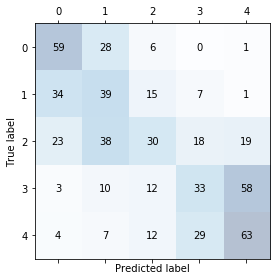

In [212]:
confmat(y_true=y1_test, y_pred=y1_pred)

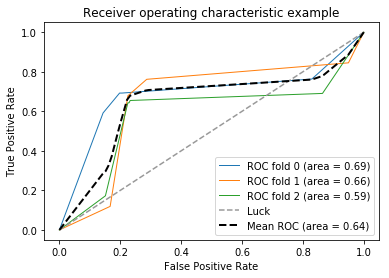

Mean AUC: 0.644


In [107]:
y01_train=y1_train.copy()
y01_train[y01_train<=2]=0
y01_train[y01_train>2]=1
tree.fit(X_train, y01_train)
ROC_CURVE(X_train,y01_train,tree)

<br>

## 4.3 Random Forest

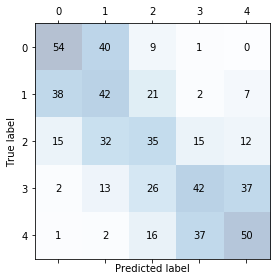

In [112]:
from sklearn.ensemble import RandomForestClassifier  
rdf = RandomForestClassifier(n_estimators=10)  
rdf = rdf.fit(X_train, y1_train)  
y1_pred=rdf.predict(X_test)
confmat(y_true=y1_test, y_pred=y1_pred)

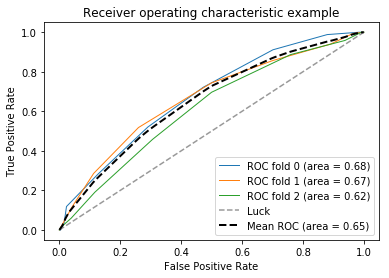

Mean AUC: 0.652


In [108]:
rdf = RandomForestClassifier(n_estimators=10)  
rdf = clf.fit(X_train, y01_train)  
ROC_CURVE(X_train,y01_train,rdf)

<br>

## 4.4 Logistic Regression

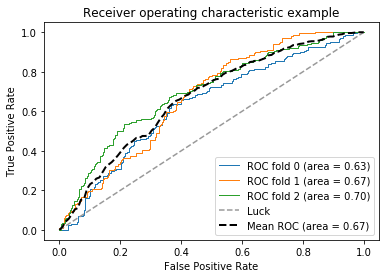

Mean AUC: 0.669


In [109]:
lgt=LogisticRegression()
lgt.fit(X_train,y01_train)
ROC_CURVE(X_train,y01_train,lgt)

<br>

## 4.5 KNN

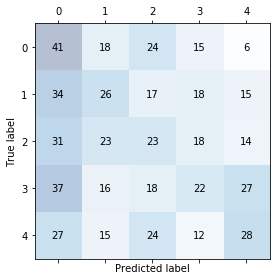

In [133]:
from sklearn import neighbors   
  
knn = neighbors.KNeighborsClassifier()    
knn.fit(X_train,y1_train) 
y1_pred=knn.predict(X_test)
confmat(y_true=y1_test, y_pred=y1_pred)

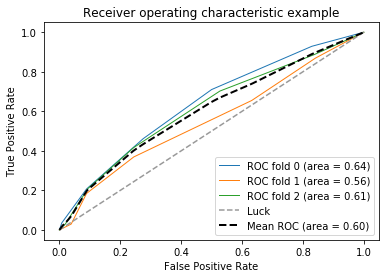

Mean AUC: 0.603


In [134]:
knn = neighbors.KNeighborsClassifier()    
knn.fit(X_train,y01_train) 
ROC_CURVE(X_train,y01_train,knn)

## 4.6 SVM

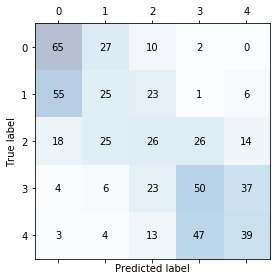

In [145]:
svm = SVC(probability=True)
svm.fit(X_train_std,y1_train_std) 
y1_pred=svm.predict(X_test_std)
confmat(y_true=y1_test_std, y_pred=y1_pred)

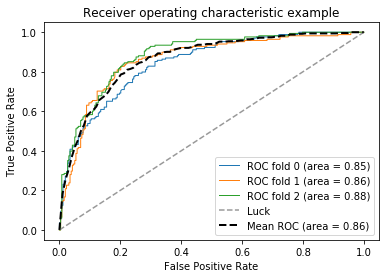

Mean AUC: 0.863


In [149]:
y01_train_std=y1_train_std.copy()
y01_train_std[y01_train_std<=2]=0
y01_train_std[y01_train_std>2]=1

svm = SVC(probability=True)
svm.fit(X_train_std,y01_train_std) 
ROC_CURVE(X_train_std,y01_train_std,svm)

## 4.7 Multi-layer Perceptron

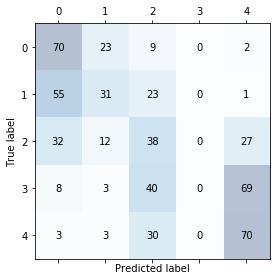

In [150]:
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(4, 2), random_state=1)
nn.fit(X_train_std,y1_train_std)                         
y1_pred=nn.predict(X_test_std)
confmat(y_true=y1_test_std, y_pred=y1_pred)

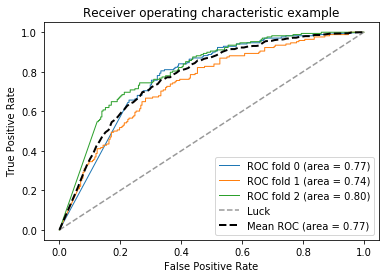

Mean AUC: 0.772


In [151]:
nn = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(4, 2), random_state=1)
nn.fit(X_train_std,y1_train_std)   
ROC_CURVE(X_train_std,y01_train_std,nn)

<br>

# 5、Summary

### 5.1 The relationship about the features and dependent variable

##### (1) Using the randon forest to test the importance of variables and find that backdoor、IPO-type、Investment Banks are more unimpotant.
##### (2) IPO_DATE，IPO_PRICE，IPO_AMOUNT，IPO_EXPENSE，and IPO_board have more significant impact to the return
##### (3) The IPO_PRICE and IPO_TIME have negative impact to the return.
##### (4) The stocks on Main-board are tend to have smaller return
##### (5) The return are going to be higher year after year. A share investors all believe the return on ipo day is high, more and more investors are trend to buy the 'new stocks'
#### (6) Some industries tends to have significant higher return: Public utility,health care, Consumer Discretionary,energy. Most these industries are emerging industry
#### (7) Investment banks like 中原证券 中国银河证券 首创证券 华安证券 兴业证券 have higher return
#### which means these investment banks tend to undervalue the stocks. 

### 5.2 The forecasting result of the ML model

##### (1) PCA has no improvement to this data
##### (2) By using K-fold and calculating the mean auc, all the model has mean auc above 0.6
#####      Neural network&svm has significant better result  0.772 and 0.863      